# Feature Analysis

In [1]:
from pyspark import SparkContext
import json
import utils
import pprint
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

In [2]:
rdd_features = sc.textFile('data/spark/features/').map(json.loads)
rdd_features.count()

49344

In [3]:
df = pd.DataFrame(rdd_features.map(lambda x: x['features']).collect())
df.head()

,firstProblemGrade,increaseGradeFromFirstToLastProblem,lastProblemGrade,percentageImprovedBetweenFirstAndLastProblem,proportionOfProblemEvents,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,totalNumberOfProblemSubmissions,totalNumberOfVideoWatched,watchedAllVideosBeforeFirstProblem,watchedSomeVideoAfterFirstProblem
0,9.69,1.0,10.0,0.999968,0.033898,1.0,0.009236,8.520023,8.529259,2,26,True,0.0
1,10.00,0.0,10.0,0.000000,0.015152,1.0,0.000000,4.715845,4.715845,1,57,True,0.0
2,10.00,0.0,10.0,0.000000,0.010526,1.0,0.000000,6.102060,6.102060,1,94,True,0.0
3,9.58,1.0,10.0,0.999976,0.039216,1.0,0.005590,2.375741,2.381331,2,49,True,0.0
4,7.09,1.0,10.0,0.999997,0.750000,0.0,6.030475,5.967859,11.998333,9,3,True,0.0


# Cleaning

In [4]:
df = df[df.timeBetweenStartAndLastProblem<15]

In [5]:
df = df[df.totalNumberOfProblemSubmissions>1]

# Feature evaluation

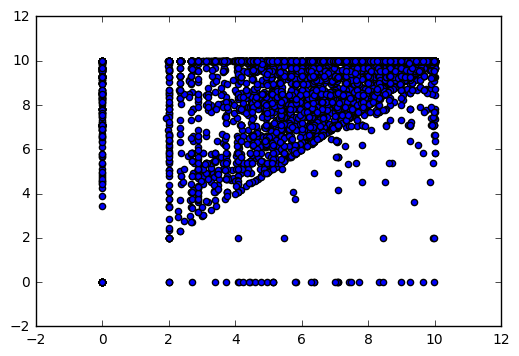

In [6]:
x= 'firstProblemGrade'
y= 'lastProblemGrade'

plt.scatter(df[x],df[y])

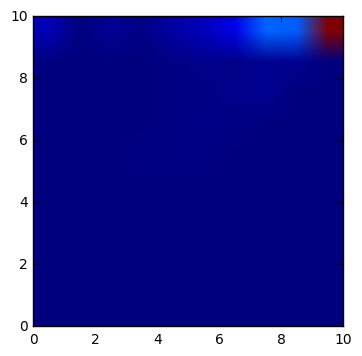

In [7]:
heatmap, xedges, yedges = np.histogram2d(df[x], df[y], bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

# Kmeans

In [8]:
FEATURES = list(df.columns)

FEATURE_AVG = {}
FEATURE_STD = {} 
for feature in FEATURES:
    FEATURE_AVG[feature] = df[feature].mean()
    FEATURE_STD[feature] = df[feature].std()

df_kmeans = pd.DataFrame([])
for feature in FEATURES:
    df_kmeans[feature] = df[feature].apply(lambda x: (x-FEATURE_AVG[feature])/FEATURE_STD[feature])

print(df_kmeans.shape)
df_kmeans.head()

(21887, 13)


,firstProblemGrade,increaseGradeFromFirstToLastProblem,lastProblemGrade,percentageImprovedBetweenFirstAndLastProblem,proportionOfProblemEvents,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,totalNumberOfProblemSubmissions,totalNumberOfVideoWatched,watchedAllVideosBeforeFirstProblem,watchedSomeVideoAfterFirstProblem
0,0.698683,0.285535,0.340049,0.482665,-0.777207,0.613333,-0.409931,1.057706,0.857416,-0.538211,-0.142281,0.564340,-0.297982
3,0.650715,0.285535,0.340049,0.482691,-0.757767,0.613333,-0.412303,-0.542652,-0.679050,-0.538211,0.190744,0.564340,-0.297982
4,-0.435111,0.285535,0.340049,0.482755,1.840852,-1.630361,3.507663,0.392962,1.724393,4.202430,-0.475306,0.564340,-0.297982
6,0.807702,0.285535,0.340049,0.482242,2.754849,-1.630361,-0.413418,-1.161444,-1.273214,-0.538211,-0.518744,-1.771901,-0.297982
7,0.075097,0.285535,0.340049,0.482748,0.926855,0.613333,-0.401279,-0.996521,-1.110306,0.139024,-0.475306,-1.771901,-0.297982


In [9]:
from sklearn.cluster import KMeans

print('running Kmeans algorithm')
print('\n___________________\n')

kmeansModel = KMeans(n_clusters=3)
kmeansModel.fit(df_kmeans)

centers = kmeansModel.cluster_centers_
labels = kmeansModel.labels_

print('student repartition')
for index in range(len(centers)):
    print(sum([label==index for label in labels])/len(labels),end='\t')
print('\n___________________\n')

for index in range(len(FEATURES)):
    feature = FEATURES[index]
    print(feature)
    for center in centers:
        print((center[index]*FEATURE_STD[feature])+FEATURE_AVG[feature],end='\t')
    print('\n') 


print('\n___________________\n')

running Kmeans algorithm

___________________

student repartition
0.113857541006	0.158724356924	0.72741810207	
___________________

firstProblemGrade
7.49862417551	7.61754894823	8.28258066924	

increaseGradeFromFirstToLastProblem
0.38066586442	0.969470046083	1.0	

lastProblemGrade
7.80237868929	9.71897753592	9.89397374111	

percentageImprovedBetweenFirstAndLastProblem
0.0905744699031	0.890510265889	0.955239833292	

proportionOfProblemEvents
0.202053654904	0.733107309278	0.147324721642	

repeatedVideoBeforeFirstProblem
0.740874448456	0.111463133641	0.858560482351	

timeBetweenFirstAndLastProblem
0.854440363574	0.733469822069	0.585064970958	

timeBetweenStartAndFirstProblem
5.61574073146	0.701970489445	5.09736299966	

timeBetweenStartAndLastProblem
6.47018109503	1.43544031151	5.68242797062	

totalNumberOfProblemSubmissions
2.58443642198	3.16359447005	2.74720512498	

totalNumberOfVideoWatched
31.7380665864	2.45564516129	43.7435623665	

watchedAllVideosBeforeFirstProblem
0.795427196149	0.

In [10]:
FEATURES

['firstProblemGrade',
 'increaseGradeFromFirstToLastProblem',
 'lastProblemGrade',
 'percentageImprovedBetweenFirstAndLastProblem',
 'proportionOfProblemEvents',
 'repeatedVideoBeforeFirstProblem',
 'timeBetweenFirstAndLastProblem',
 'timeBetweenStartAndFirstProblem',
 'timeBetweenStartAndLastProblem',
 'totalNumberOfProblemSubmissions',
 'totalNumberOfVideoWatched',
 'watchedAllVideosBeforeFirstProblem',
 'watchedSomeVideoAfterFirstProblem']

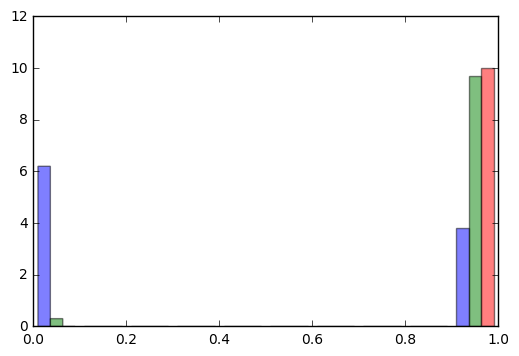

In [11]:
x = 'increaseGradeFromFirstToLastProblem'

plt.hist((
    df[[label==0 for label in labels]][x],
    df[[label==1 for label in labels]][x],
    df[[label==2 for label in labels]][x]), 
    10, normed=1, alpha=0.5
)

plt.show()

# ANOVA tests

In [12]:
from scipy import stats

x = 'lastProblemGrade'

print(stats.ttest_ind(
    df_kmeans[[label==0 for label in labels]][x].values,
    df_kmeans[[label==1 for label in labels]][x].values
))

print(stats.ttest_ind(
    df_kmeans[[label==1 for label in labels]][x].values,
    df_kmeans[[label==2 for label in labels]][x].values
))

print(stats.ttest_ind(
    df_kmeans[[label==2 for label in labels]][x].values,
    df_kmeans[[label==0 for label in labels]][x].values
))

Ttest_indResult(statistic=-46.342971146440377, pvalue=0.0)
Ttest_indResult(statistic=-20.081022952097069, pvalue=8.6381846494018151e-89)
Ttest_indResult(statistic=109.36898125387512, pvalue=0.0)


# PCA 

In [13]:
from sklearn.decomposition import PCA
X = df_kmeans.values.tolist()
pca = PCA(n_components=13, whiten=True)
pca.fit(X)

print(pca.explained_variance_ratio_)

[  2.20034916e-01   1.72869356e-01   1.29964145e-01   1.04027410e-01
   8.20791961e-02   6.77856334e-02   6.06403591e-02   5.54692594e-02
   4.35381601e-02   3.42197484e-02   1.82123189e-02   1.11594979e-02
   2.22487334e-31]


In [14]:
print('________________\n')
for component in pca.components_:
    c_abs = [abs(c) for c in component]
    indexes = [i[0] for i in sorted(enumerate(c_abs), key=lambda x:-x[1])]
    for index in indexes[:3]:
        print(FEATURES[index], component[index])
    print(component)
    print('________________\n')

________________

proportionOfProblemEvents -0.480516184465
timeBetweenStartAndFirstProblem 0.444978333683
timeBetweenStartAndLastProblem 0.432743528972
[ 0.04512422 -0.00397592  0.02023743 -0.0045368  -0.48051618  0.39416961
  0.01505713  0.44497833  0.43274353 -0.04445602  0.23568449  0.41015639
 -0.00109597]
________________

percentageImprovedBetweenFirstAndLastProblem -0.582651719407
lastProblemGrade -0.514365624937
increaseGradeFromFirstToLastProblem -0.462861204778
[-0.25098895 -0.4628612  -0.51436562 -0.58265172  0.08370684 -0.08423457
  0.17194688  0.12138329  0.1825154   0.10510499 -0.07294847 -0.05594797
  0.08658241]
________________

totalNumberOfProblemSubmissions 0.47436309751
timeBetweenFirstAndLastProblem 0.435263002621
firstProblemGrade -0.423330754937
[ -4.23330755e-01   3.69050540e-01  -3.85908467e-04   2.83770200e-01
   1.08416513e-01  -6.31884301e-02   4.35263003e-01   9.08319146e-02
   2.54344654e-01   4.74363098e-01  -3.63692079e-02  -6.86876731e-02
   3.0799933